# Binary Classification with CNNs and Pretraining: Chest X-Ray Images (Pneumonia)

## Setup

In [9]:
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import datetime

notebook_start_time = datetime.datetime.now()

In [10]:
test_dir = "data/test"
train_dir = "data/train"
validation_dir = "data/val"

batch_size = 32

# this api defaults to rgb images, even though they're actually grayscale
height, width, channels = 150, 150, 3

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(height, width),
    batch_size=batch_size,
    label_mode='int',
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=(height, width),
    batch_size=batch_size,
    label_mode='int',
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(height, width),
    batch_size=batch_size,
    label_mode='int',
)

# because the outputs are batched, we have to concatenate all the batches
y_true = np.concatenate([y for x, y in test_ds], axis=0)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [11]:
def summary_graphics(history, model):
    y_pred = np.round(model.predict(test_ds))
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(16, 5)
    ax = ax.flatten()

    # true/false positive/negative rates (better than accuracy for imbalanced data!)
    ax[0].plot(history.history['tp'], label = 'True Positives', color='g')
    #ax[0].plot(history.history['fp'], label = 'False Positives')
    ax[0].plot(history.history['tn'], label = 'True Negatives', color='r')
    #ax[0].plot(history.history['fn'], label = 'False Negatives', color='orange')
    ax[0].grid(True)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Metric Value')
    ax[0].legend(loc='right')
    ax[0].set_title('True Positive and True Negative Rates')

    # loss
    ax[1].plot(history.history['loss'], label='Loss')
    ax[1].plot(history.history['val_loss'], label = 'Val Loss')
    ax[1].grid(True)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend(loc='upper right')
    ax[1].set_title('Loss')

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[2])
    ax[2].set_xlabel('Predicted')
    ax[2].set_ylabel('True')
    ax[2].xaxis.set_ticklabels([f'Normal ({(cm[0][0] + cm[1][0])/len(y_pred):.3f})', f'Pneumonia ({(cm[0][1] + cm[1][1])/len(y_pred):.3f})'])
    ax[2].yaxis.set_ticklabels([f'Normal ({(cm[0][0] + cm[0][1])/len(y_pred):.3f})', f'Pneumonia ({(cm[1][0] + cm[1][1])/len(y_pred):.3f})'])
    ax[2].set_title('Confusion Matrix')

    plt.show()

def get_class_training_weights(train_ds, normalize = True):
    labels, counts = np.unique(np.concatenate([y for x, y in train_ds], axis=0), return_counts=True)
    total = sum(counts)

    weights = [total/(2*count) for count in counts]
    max_weight = np.max(weights)

    if normalize:
        return {l : weights[i]/max_weight for i, l in enumerate(labels)}

    return {l : weights[i] for i, l in enumerate(labels)}

In [12]:
class_weight = get_class_training_weights(train_ds=train_ds)

print(f"Weight for normal class: {class_weight[0]:1.3f}")
print(f"Weight for pneumonia class: {class_weight[1]:1.3f}")

Weight for normal class: 1.000
Weight for pneumonia class: 0.346


2025-04-27 13:34:41.342830: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
vgg19 = tf.keras.applications.VGG19() # default parameters are fine
vgg19.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,31

 Total params: 143,667,240 (548.05 MB)

 Trainable params: 143,667,240 (548.05 MB)

 Non-trainable params: 0 (0.00 B)

## Training

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer((height, width, channels), name="input"),

    tf.keras.layers.RandomFlip("horizontal", name="0.1rflip"),
    tf.keras.layers.RandomRotation(0.2, name="0.2rrot"),
    tf.keras.layers.RandomBrightness(0.2, name="0.3rbright"),
    tf.keras.layers.RandomContrast(0.2, name="0.4rcont"),
    tf.keras.layers.RandomTranslation(0.2, 0.2, name="0.5rtran"),
    tf.keras.layers.RandomZoom(0.2, name="0.6rzoom"),

    # the model "starts" after the augmentation layers
    tf.keras.layers.Rescaling(1./255, name="rescale"),

    # vgg19 expects 244x244 images
    tf.keras.layers.Resizing(244, 244, name="resize"),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', name="1.1conv"),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', name="1.2conv"),
    tf.keras.layers.MaxPooling2D((2,2), name="1.3pool"),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', name="2.1conv"),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', name="2.2conv"),
    tf.keras.layers.MaxPooling2D((2,2), name="2.3pool"),

    # the xception paper says every convolutional layer is followed by a batch normalization layer
    # i'm willing to bet modern techniques might have moved away from this, but we'll try it anyway
    # however, we make an exception for the pretrained layers, since they're already trained

    # the rest of the convolutional layers in Xception are blocks of 2-3 depthwise separable layers, followed by a pooling layer
    tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name="3.1conv"),
    tf.keras.layers.BatchNormalization(name="3.2batchnorm"),
    tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name="3.3conv"),
    tf.keras.layers.BatchNormalization(name="3.4batchnorm"),
    tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name="3.5conv"),
    tf.keras.layers.BatchNormalization(name="3.6batchnorm"),
    tf.keras.layers.MaxPooling2D((2,2), name='3.7pool'),

    tf.keras.layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name="4.1conv"),
    tf.keras.layers.BatchNormalization(name="4.2batchnorm"),
    tf.keras.layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name='4.3conv'),
    tf.keras.layers.BatchNormalization(name="4.4batchnorm"),
    tf.keras.layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name="4.5conv"),
    tf.keras.layers.BatchNormalization(name="4.6batchnorm"),
    tf.keras.layers.MaxPooling2D((2,2), name="4.7pool"),

    # all the CNN models end with dense layers, probably to help the model "interpret" what the convolutional layers see
    tf.keras.layers.Flatten(name="5.1flatten"),

    # we almost certainly don't need these many neurons, but nain used that many and maybe he knows something I don't
    tf.keras.layers.Dense(1024, activation='relu', name="5.2dense"),
    # the above dense layer has 118 million of the 119 million trainable parameters!!!
    # add in a dropout layer with a high rate to prevent overfitting
    tf.keras.layers.Dropout(0.7, name="5.3dropout"),
    tf.keras.layers.Dense(512, activation='relu', name="5.4dense"),
    tf.keras.layers.Dropout(0.7, name="5.5dropout"),
    # 1 output neuron with sigmoid is equivalent to 2 output neurons with softmax, but trains faster:
    # https://stats.stackexchange.com/questions/207049/neural-network-for-binary-classification-use-1-or-2-output-neurons
    #tf.keras.layers.Dense(2, activation="softmax", name="output")
    tf.keras.layers.Dense(1, activation="sigmoid", name="output")
], name="Model_1")

# let's try AdamW
model.compile(
    optimizer=tf.keras.optimizers.AdamW(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    ]
)

model.get_layer("1.1conv").set_weights(vgg19.get_layer('block1_conv1').get_weights())
model.get_layer("1.2conv").set_weights(vgg19.get_layer('block1_conv2').get_weights())
model.get_layer("2.1conv").set_weights(vgg19.get_layer('block2_conv1').get_weights())
model.get_layer("2.2conv").set_weights(vgg19.get_layer('block2_conv2').get_weights())
model.get_layer("1.1conv").trainable = False
model.get_layer("1.2conv").trainable = False
model.get_layer("2.1conv").trainable = False
model.get_layer("2.2conv").trainable = False

model.summary()

Model: "Model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ 0.1rflip (RandomFlip)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 0.2rrot (RandomRotation)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 0.3rbright (RandomBrightness)   │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 0.4rcont (RandomContrast)       │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 0.5rtran (RandomTranslation)    │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 0.6rzoom (RandomZoom)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescale (Rescaling)             │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resize (Resizing)               │ (None, 244, 244, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1.1conv (Conv2D)                │ (None, 244, 244, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1.2conv (Conv2D)                │ (None, 244, 244, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1.3pool (MaxPooling2D)          │ (None, 122, 122, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2.1conv (Conv2D)                │ (None, 122, 122, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2.2conv (Conv2D)                │ (None, 122, 122, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2.3pool (MaxPooling2D)          │ (None, 61, 61, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.1conv (SeparableConv2D)       │ (None, 61, 61, 256)    │        34,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.2batchnorm                    │ (None, 61, 61, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.3conv (SeparableConv2D)       │ (None, 61, 61, 256)    │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.4batchnorm                    │ (None, 61, 61, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.5conv (SeparableConv2D)       │ (None, 61, 61, 256)    │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.6batchnorm                    │ (None, 61, 61, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.7pool (MaxPooling2D)          │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 4.1conv (SeparableConv2D)       │ (None, 30, 30, 512)    │       133,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 4.2batchnorm                    │ (None, 30, 30, 512)    │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 119,599,297 (456.24 MB)

 Trainable params: 119,334,529 (455.23 MB)

 Non-trainable params: 264,768 (1.01 MB)

In [15]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=10,
    class_weight=class_weight,
    verbose=1,
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 905s 5s/step - accuracy: 0.7042 - loss: 9.1085 - precision: 0.8571 - recall: 0.7149 - tn: 480.3171 - tp: 1425.3964 - val_accuracy: 0.5000 - val_loss: 2.7344 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 8.0000 - val_tp: 0.0000e+00
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 842s 5s/step - accuracy: 0.7802 - loss: 0.2968 - precision: 0.9108 - recall: 0.7781 - tn: 554.0488 - tp: 1511.1097 - val_accuracy: 0.5000 - val_loss: 0.7053 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 8.0000 - val_tp: 0.0000e+00
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 859s 5s/step - accuracy: 0.8076 - loss: 0.2180 - precision: 0.9422 - recall: 0.7875 - tn: 599.3171 - tp: 1527.2744 - val_accuracy: 0.5000 - val_loss: 0.7063 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 8.0000
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 868s 5s/step - accuracy: 0.8288 - loss: 0.1919 - precision: 0.9511 - recall: 0.8088 - tn: 609.9268 - tp:

20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step


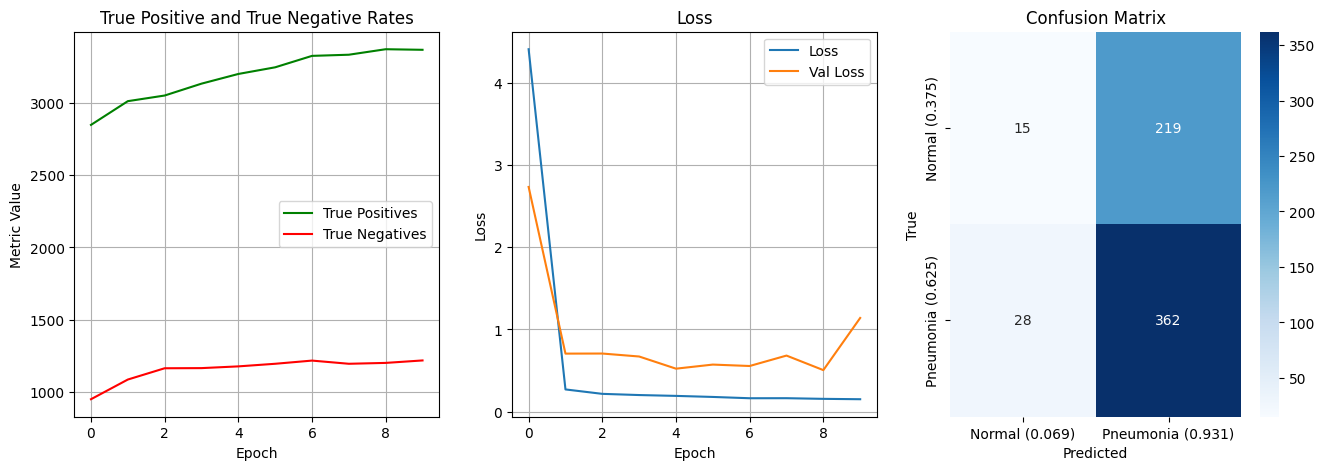

In [18]:
summary_graphics(history, model)

In [19]:
# maybe the vgg16 weights are better
vgg16 = tf.keras.applications.VGG16()  # default parameters are fine
vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# remove the last batch normalization layers from each block, like Nain did
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer((height, width, channels), name="input"),

    tf.keras.layers.RandomFlip("horizontal", name="0.1rflip"),
    tf.keras.layers.RandomRotation(0.2, name="0.2rrot"),
    tf.keras.layers.RandomBrightness(0.2, name="0.3rbright"),
    tf.keras.layers.RandomContrast(0.2, name="0.4rcont"),
    tf.keras.layers.RandomTranslation(0.2, 0.2, name="0.5rtran"),
    tf.keras.layers.RandomZoom(0.2, name="0.6rzoom"),

    # the model "starts" after the augmentation layers
    tf.keras.layers.Rescaling(1./255, name="rescale"),

    # vgg19 expects 244x244 images
    tf.keras.layers.Resizing(244, 244, name="resize"),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', name="1.1conv"),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', name="1.2conv"),
    tf.keras.layers.MaxPooling2D((2,2), name="1.3pool"),

    # Nain's model has SeparableConv2D layers here, but the VGG16 model has Conv2D layers
    # I don't think tensorflow allows transferring regular conv2d weights to separable conv2d layers
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', name="2.1conv"),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', name="2.2conv"),
    tf.keras.layers.MaxPooling2D((2,2), name="2.3pool"),

    # the xception paper says every convolutional layer is followed by a batch normalization layer
    # i'm willing to bet modern techniques might have moved away from this, but we'll try it anyway
    # however, we make an exception for the pretrained layers, since they're already trained

    # the rest of the convolutional layers in Xception are blocks of 2-3 depthwise separable layers, followed by a pooling layer
    tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name="3.1conv"),
    tf.keras.layers.BatchNormalization(name="3.2batchnorm"),
    tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name="3.3conv"),
    tf.keras.layers.BatchNormalization(name="3.4batchnorm"),
    tf.keras.layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name="3.5conv"),
    tf.keras.layers.MaxPooling2D((2,2), name='3.6pool'),

    tf.keras.layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name="4.1conv"),
    tf.keras.layers.BatchNormalization(name="4.2batchnorm"),
    tf.keras.layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name='4.3conv'),
    tf.keras.layers.BatchNormalization(name="4.4batchnorm"),
    tf.keras.layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name="4.5conv"),
    tf.keras.layers.MaxPooling2D((2,2), name="4.6pool"),

    # all the CNN models end with dense layers, probably to help the model "interpret" what the convolutional layers see
    tf.keras.layers.Flatten(name="5.1flatten"),

    # we almost certainly don't need these many neurons, but nain used that many and maybe he knows something I don't
    tf.keras.layers.Dense(1024, activation='relu', name="5.2dense"),
    # the above dense layer has 118 million of the 119 million trainable parameters!!!
    # add in a dropout layer with a high rate to prevent overfitting
    tf.keras.layers.Dropout(0.7, name="5.3dropout"),
    tf.keras.layers.Dense(512, activation='relu', name="5.4dense"),
    tf.keras.layers.Dropout(0.7, name="5.5dropout"),
    # 1 output neuron with sigmoid is equivalent to 2 output neurons with softmax, but trains faster:
    # https://stats.stackexchange.com/questions/207049/neural-network-for-binary-classification-use-1-or-2-output-neurons
    #tf.keras.layers.Dense(2, activation="softmax", name="output")
    tf.keras.layers.Dense(1, activation="sigmoid", name="output")
], name="Model_2")

# let's use Adam instead of AdamW
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    ]
)

model.get_layer("1.1conv").set_weights(vgg16.get_layer('block1_conv1').get_weights())
model.get_layer("1.2conv").set_weights(vgg16.get_layer('block1_conv2').get_weights())
model.get_layer("2.1conv").set_weights(vgg16.get_layer('block2_conv1').get_weights())
model.get_layer("2.2conv").set_weights(vgg16.get_layer('block2_conv2').get_weights())
model.get_layer("1.1conv").trainable = False
model.get_layer("1.2conv").trainable = False
model.get_layer("2.1conv").trainable = False
model.get_layer("2.2conv").trainable = False

model.summary()

Model: "Model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ 0.1rflip (RandomFlip)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 0.2rrot (RandomRotation)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 0.3rbright (RandomBrightness)   │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 0.4rcont (RandomContrast)       │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 0.5rtran (RandomTranslation)    │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 0.6rzoom (RandomZoom)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescale (Rescaling)             │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resize (Resizing)               │ (None, 244, 244, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1.1conv (Conv2D)                │ (None, 244, 244, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1.2conv (Conv2D)                │ (None, 244, 244, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1.3pool (MaxPooling2D)          │ (None, 122, 122, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2.1conv (Conv2D)                │ (None, 122, 122, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2.2conv (Conv2D)                │ (None, 122, 122, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2.3pool (MaxPooling2D)          │ (None, 61, 61, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.1conv (SeparableConv2D)       │ (None, 61, 61, 256)    │        34,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.2batchnorm                    │ (None, 61, 61, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.3conv (SeparableConv2D)       │ (None, 61, 61, 256)    │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.4batchnorm                    │ (None, 61, 61, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.5conv (SeparableConv2D)       │ (None, 61, 61, 256)    │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3.6pool (MaxPooling2D)          │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 4.1conv (SeparableConv2D)       │ (None, 30, 30, 512)    │       133,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 4.2batchnorm                    │ (None, 30, 30, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 4.3conv (SeparableConv2D)       │ (None, 30, 30, 512)    │       267,264 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 119,596,225 (456.22 MB)

 Trainable params: 119,332,993 (455.22 MB)

 Non-trainable params: 263,232 (1.00 MB)

In [21]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=10,
    class_weight=class_weight,
    verbose=1,
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1013s 6s/step - accuracy: 0.7530 - loss: 0.2615 - precision: 0.9001 - recall: 0.7458 - tn: 564.5793 - tp: 1483.9573 - val_accuracy: 0.5000 - val_loss: 0.6940 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 8.0000 - val_tp: 0.0000e+00
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 860s 5s/step - accuracy: 0.8295 - loss: 0.1941 - precision: 0.9597 - recall: 0.8010 - tn: 626.3415 - tp: 1570.7683 - val_accuracy: 0.5000 - val_loss: 0.7115 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 8.0000
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1122s 7s/step - accuracy: 0.8458 - loss: 0.1727 - precision: 0.9636 - recall: 0.8215 - tn: 629.6768 - tp: 1579.7805 - val_accuracy: 0.5000 - val_loss: 0.7335 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 8.0000
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1079s 7s/step - accuracy: 0.8574 - loss: 0.1582 - precision: 0.9703 - recall: 0.8313 - tn: 642.2317 - tp: 1622

20/20 ━━━━━━━━━━━━━━━━━━━━ 79s 4s/step


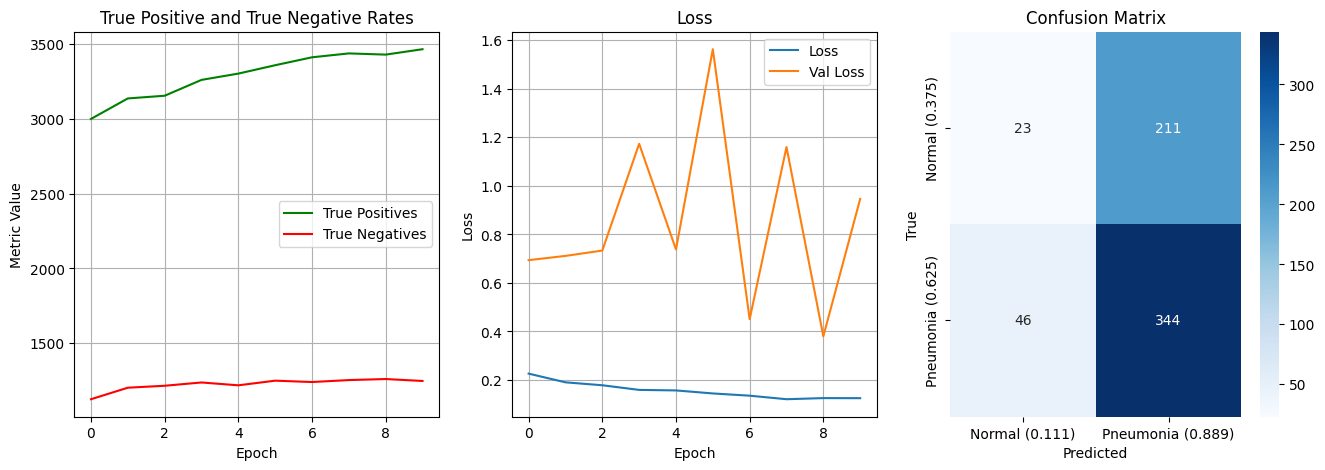

In [22]:
summary_graphics(history, model)

In [17]:
notebook_end_time = datetime.datetime.now()
print(f"Notebook last run (end-to-end): {notebook_end_time} (duration: {notebook_end_time - notebook_start_time})")

Notebook last run (end-to-end): 2025-04-27 16:00:07.486925 (duration: 2:25:38.362105)
